# Import Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd

import cv2
import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
#   DataGenerator to read images and rescale images
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#   count each class samples
from collections import Counter
import random
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score 
from sklearn.metrics import accuracy_score, classification_report
 
# Different layers
from keras.models import Sequential
from keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Softmax
from keras.initializers import GlorotUniformV2




ModuleNotFoundError: No module named 'tensorflow'

# Data Augmentation and Data Loading 

In [2]:
## Set Path Here before running the code
WORKING_DIRECTORY =  "/kaggle/input/kidney-diseases-recognition/dataset"
##  Name of classes
CLASSES = ['Cyst',
           'Normal',
           'Stone',
           'Tumor']

In [3]:
## from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your data augmentation parameters
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    horizontal_flip=True,
    width_shift_range=0.2,
 
)



# Load and augment images
train_dataset = datagen.flow_from_directory(
    WORKING_DIRECTORY,
    target_size=(224, 224),
    batch_size=200,
    shuffle=True
)

# Separate dataset from Data Generator
X, y = train_dataset.next()


Found 12446 images belonging to 4 classes.


In [4]:
samples_before = len(X)
print("Images shape :\t", X.shape)
print("Labels shape :\t", y.shape)

Images shape :	 (200, 224, 224, 3)
Labels shape :	 (200, 4)


# Balancing Class Data 


In [5]:
# SMOTE
X = X.reshape(-1, 224 * 224 * 3)
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)
X = X.reshape(-1, 224, 224, 3)

print(X.shape) 
print(y.shape)  


(332, 224, 224, 3)
(332, 4)


In [6]:
print("Number of samples in each class:\t", sorted(Counter(np.argmax(y, axis=1)).items()))
print("Classes Names according to index:\t", train_dataset.class_indices)

Number of samples in each class:	 [(0, 83), (1, 83), (2, 83), (3, 83)]
Classes Names according to index:	 {'Cyst': 0, 'Normal': 1, 'Stone': 2, 'Tumor': 3}


# Visualization Data

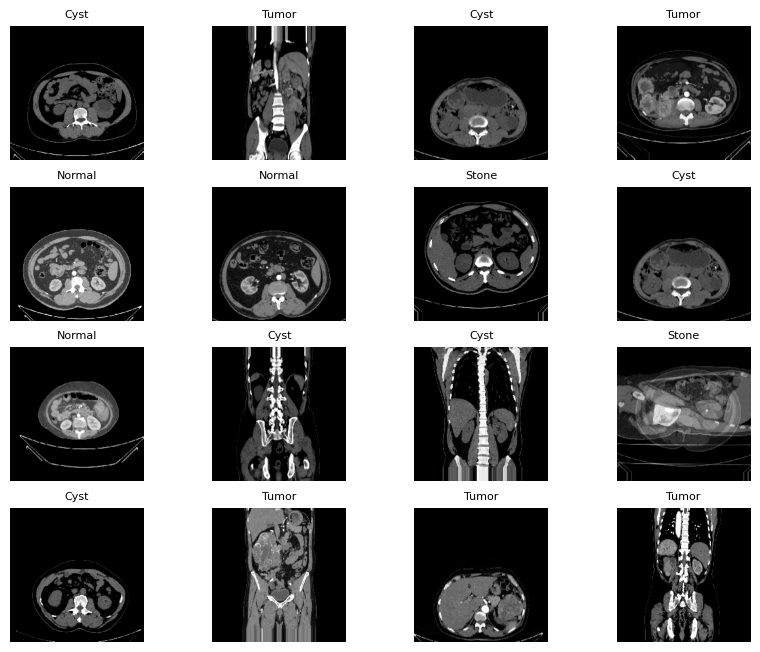

In [7]:
#   show some images
fig = plt.figure(figsize=(10,8))

rows = 4
columns = 4

for i in range(rows * columns):
    fig.add_subplot(rows, columns, i+1)
    num = random.randint(0, len(X)-1 )
    plt.imshow(X[num])
    plt.axis('off')
    plt.title(CLASSES[(np.argmax(y[num]))], fontsize=8)
plt.axis('off')
plt.show()

#  Splitting Data 

In [8]:
#   Split ratio
X_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)
print("Number of samples after splitting into Training, validation & test set\n")
print("Train     \t",sorted(Counter(np.argmax(y_train, axis=1)).items()))
print("Test      \t",sorted(Counter(np.argmax(y_test, axis=1)).items()))

Number of samples after splitting into Training, validation & test set

Train     	 [(0, 62), (1, 55), (2, 58), (3, 57)]
Test      	 [(0, 21), (1, 28), (2, 25), (3, 26)]


# Models

* **Deep Feature Fusion Network (DFFN)**

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU, Softmax, Input

init = tf.keras.initializers.GlorotUniform()

model = Sequential()

# Input layer
model.add(Input(shape=(224, 224, 3)))

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer=init, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer=init, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer=init, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer=init, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(Flatten())

# Fully connected layers
model.add(Dense(256, activation='relu', kernel_initializer=init))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(4, activation='softmax', kernel_initializer=init))

# Model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                      

/opt/conda/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [36]:
# Train model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
6/6 [==============================] - 14s 2s/step - loss: 31.3341 - accuracy: 0.3243 - val_loss: 1.5567 - val_accuracy: 0.3191
Epoch 2/50
6/6 [==============================] - 12s 2s/step - loss: 12.0056 - accuracy: 0.4162 - val_loss: 1.9667 - val_accuracy: 0.3404
Epoch 3/50
6/6 [==============================] - 13s 2s/step - loss: 4.2146 - accuracy: 0.5351 - val_loss: 1.7190 - val_accuracy: 0.3191
Epoch 4/50
6/6 [==============================] - 13s 2s/step - loss: 1.9316 - accuracy: 0.5946 - val_loss: 1.4778 - val_accuracy: 0.3404
Epoch 5/50
6/6 [==============================] - 12s 2s/step - loss: 1.7300 - accuracy: 0.5784 - val_loss: 1.6588 - val_accuracy: 0.3404
Epoch 6/50
6/6 [==============================] - 13s 2s/step - loss: 1.4753 - accuracy: 0.5730 - val_loss: 2.1480 - val_accuracy: 0.1702
Epoch 7/50
6/6 [==============================] - 12s 2s/step - loss: 0.9995 - accuracy: 0.5784 - val_loss: 2.4789 - val_accuracy: 0.2128
Epoch 8/50
6/6 [================

In [37]:
# Evaluate model 
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss:.2f}")
print(f"Test Accuracy: {accuracy:.2f}")

4/4 [==============================] - 2s 371ms/step - loss: 19.0327 - accuracy: 0.2800
Test Loss: 19.03
Test Accuracy: 0.28
